# Uncertainty Awareness in Deep Learning using SNGP

In AI applications that are safety-critical, such as medical decision making and autonomous driving, or where the data is inherently noisy (for example, natural language understanding), it is important for a deep classifier to reliably quantify its uncertainty. The deep classifier should be able to be aware of its own limitations and when it should hand control over to the human experts. This tutorial shows how to improve a deep classifier's ability in quantifying uncertainty using a technique called **[Spectral-normalized Neural Gaussian Process (SNGP)](https://arxiv.org/abs/2006.10108)**.

The core idea of SNGP is to improve a deep classifier's _**distance awareness**_ by applying simple modifications to the network. A model's _distance awareness_ is a measure of how its predictive probability reflects the distance between the test example and the training data. This is a desirable property that is common for gold-standard probabilistic models (for example, the [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) with RBF kernels) but is lacking in models with deep neural networks. SNGP provides a simple way to inject this Gaussian-process behavior into a deep classifier while maintaining its predictive accuracy.

This notebooks implements a deep residual network (ResNet)-based SNGP model on [scikit-learn’s two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset, and compares its uncertainty surface with that of two other popular uncertainty approaches: [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474).

This tutorial illustrates the SNGP model on a toy 2D dataset. For an example of applying SNGP to a real-world natural language understanding task using a BERT-base, check out the [SNGP-BERT tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert). For high-quality implementations of an SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc), refer to the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## About SNGP

SNGP is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

* It applies spectral normalization to the hidden residual layers.
* It replaces the Dense output layer with a Gaussian process layer.

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Compared to other uncertainty approaches (such as Monte Carlo dropout or Deep ensemble), SNGP has several advantages:

* It works for a wide range of state-of-the-art residual-based architectures (for example, (Wide) ResNet, DenseNet, or BERT).
* It is a single-model method—it does not rely on ensemble averaging. Therefore, SNGP has a similar level of latency as a single deterministic network, and can be scaled easily to large datasets like [ImageNet](https://github.com/google/uncertainty-baselines/tree/main/baselines/imagenet) and [Jigsaw Toxic Comments classification](https://github.com/google/uncertainty-baselines/tree/main/baselines/toxic_comments).
* It has strong out-of-domain detection performance due to the _distance-awareness_ property.

The downsides of this method are:

* The predictive uncertainty of SNGP is computed using the [Laplace approximation](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf). Therefore, theoretically, the posterior uncertainty of SNGP is different from that of an exact Gaussian process.

* SNGP training needs a covariance reset step at the beginning of a new epoch. This can add a tiny amount of extra complexity to a training pipeline. This tutorial shows a simple way to implement this using Keras callbacks.

## Setup

In [20]:
pip freeze | grep  tf-models-official || pip install --use-deprecated=legacy-resolver tf-models-official

tf-models-official==2.9.2
Note: you may need to restart the kernel to use updated packages.


**Note:** you may need to restart the kernel to use updated packages.

In [84]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import tensorflow as tf
from official.nlp.modeling.layers import (
    RandomFeatureGaussianProcess,
    SpectralNormalization,
    gaussian_process,
)

In [22]:
plt.rcParams["figure.dpi"] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(
    vmin=0,
    vmax=1,
)
DEFAULT_N_GRID = 100
NOISE = 0.1

## The two moon dataset

In this notebook, we will demonstrate how to implement SNGP using a simple synthetic dataset,  the [scikit-learn two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). The following function creates the training dataset. (The amount of noise in the data can be controlled by the noise argument.)

In [85]:
def make_training_data(sample_size=500, noise=NOISE):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=noise
    )

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

Since we will be interested in understanding how our model behaves also outside of the data distribution support, the following function
generates a test dataset with points in a grid within `DEFAULT_X_RANGE` and `DEFAULT_Y_RANGE`, which we will use to visualize the confidence of our model within that grid.

In [24]:
def make_testing_data(
    x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID
):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To numerically evaluate our model uncertainty, we create an additional **out-of-domain (OOD)** of points grouped in a small cluster away from the training points. The model never observes these OOD examples during training.

In [25]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), variances=(0.01, 0.01)):
    return np.random.multivariate_normal(
        means, cov=np.diag(variances), size=sample_size
    )

Let us now visuzlize our training points (blue and orange) as well as our out-of-domain points (red)"

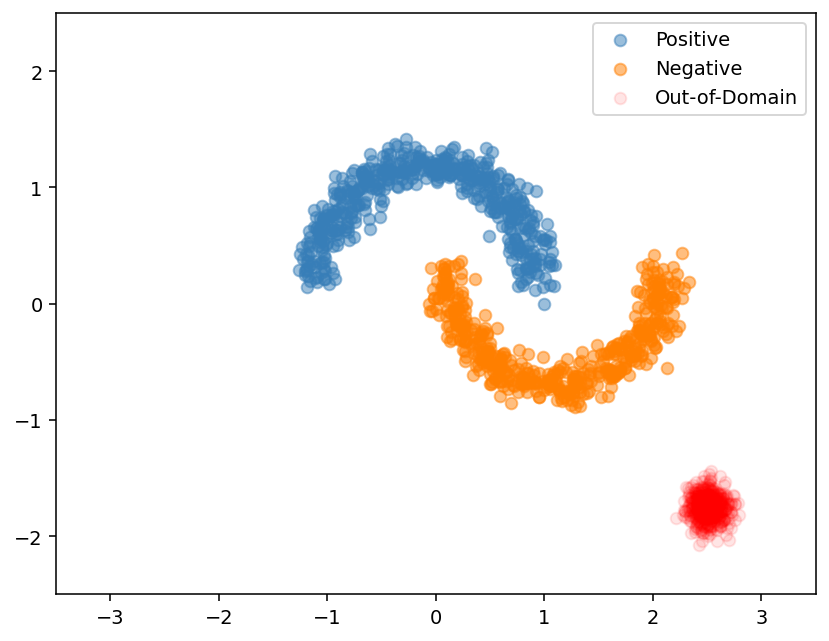

In [26]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

In the plot above, the blue and orange represent the positive and negative classes, and the red represents the OOD data. 

> **Important:** A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5). Namely, our goal is to devise mechanisms preventing a model from beeing confidently wrong on input points that are very different from those seen during training. 

## The deterministic model

We start by a implementing a model with no special mechanism to deal with OOD data points, which we will take as our baseline. The architecture is a standard multi-layer residual network (ResNet) with dropout regularization. Our goal next will be to tweak this model to make it uncertainty aware using SNGP, which will add a probabilistic layer to it.

In [168]:
class DeepResNet(tf.keras.Model):
    """Defines a multi-layer residual network."""

    def __init__(
        self,
        num_classes,
        num_layers=3,
        num_hidden=128,
        dropout_rate=0.1,
        **classifier_kwargs,
    ):
        super().__init__()
        # Defines class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        # Defines the hidden layers.
        self.input_layer = tf.keras.layers.Dense(
            self.num_hidden, trainable=False
        )
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

        # Defines the output layer.
        self.classifier = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            hidden += resid

        return self.classifier(hidden)

    def make_dense_layer(self):
        """Uses the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, num_classes):
        """Uses the Dense layer as the output layer."""
        return tf.keras.layers.Dense(num_classes, **self.classifier_kwargs)

Let us define our model with six ResNet layers of with 128 hidden units each:

In [173]:
resnet_config = dict(num_classes=1, num_layers=6, num_hidden=128)

resnet_model = DeepResNet(**resnet_config)

resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           multiple                  384       
                                                                 
 dense_149 (Dense)           multiple                  16512     
                                                                 
 dense_150 (Dense)           multiple                  16512     
                                                                 
 dense_151 (Dense)           multiple                  16512     
                                                                 
 dense_152 (Dense)           multiple                  16512     
                                                                 
 dense_153 (Dense)           multiple                  16512     
                                                                 
 dense_154 (Dense)           multiple              

### Train model

The following cell defines the training configurations. Since the model outpus the logits for the classes and not not the probabilities, we use the `SparseCategoricalCrossentropy` with `from_logits=True`:

In [176]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = (tf.keras.metrics.BinaryAccuracy(),)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=100)

Let us now train the model:

In [ ]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

### Visualize uncertainty

The following functions visualizes the model incertainty by plotting uncertainty values (passed as the `test_uncertainty` array) of our model  at the 2D grid points stored in `test_examples`. (The function also takes a matplotlib `Axes` object in the parameter `ax` indicating where to display the plot as well as a the color palette to use in the `cmap` argument.)

In [178]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
        np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
        cmap=cmap,
        origin="lower",
        extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
        vmin=DEFAULT_NORM.vmin,
        vmax=DEFAULT_NORM.vmax,
        interpolation="bicubic",
        aspect="auto",
    )

    # Plot training data.
    ax.scatter(
        train_examples[:, 0],
        train_examples[:, 1],
        c=train_labels,
        cmap=DEFAULT_CMAP,
        alpha=0.5,
    )
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

Now we can visualize the uncertainty in the predictions of our model in two ways. 


The first way is to plot the class probability values directly: i.e.,

$$p(x) = \textrm{softmax}(\textrm{logit}(x))$$

Note that we defined our model to output logit scores for each of the classes, so in the two moon dataset case the output is two-dimensional rather than one-dimensional as is common for binary classifiers. Because of that, to obtain the class probabilities from the logit scores, we need to pass these logit scores to a final softmax layer rather than a sigmoid layer. Then we can plot the probability of the first class on the 2D test point grid using the function `plot_uncertainty_surface`:

In [190]:
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.sigmoid(resnet_logits)

A class probability value close to 0 or 1 at a input point indicates that the model is very confident in its predictions at this point, while a probability value close to  0.5 indicates that the model is uncertain. We see that our baseline model is very confident far away of the data distribution support, including on our small patch of red OOD points:

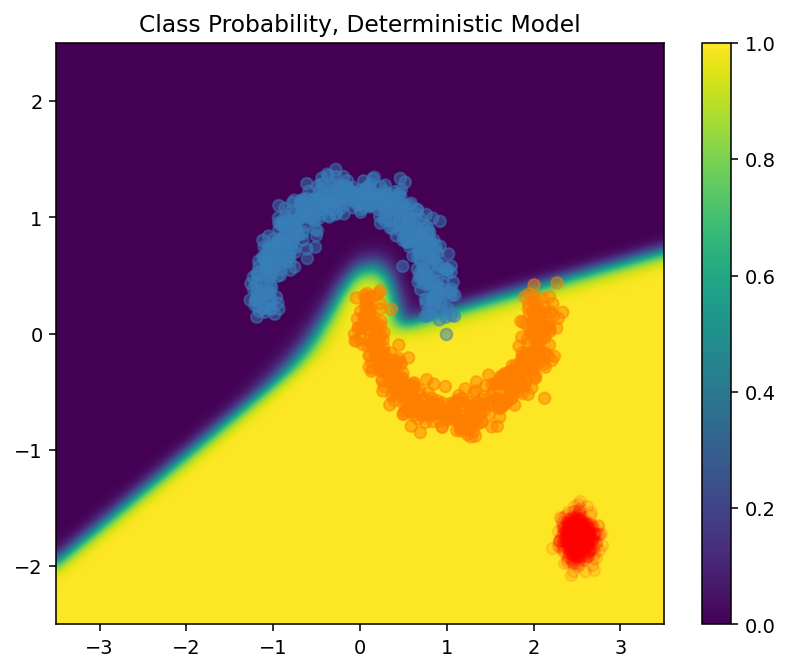

In [191]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In the plot above, the yellow and purple are the predictive probabilities for the two classes. The deterministic model did a good job in classifying the two known classes (blue and orange points) with a nonlinear decision boundary. However, it is not **distance-aware**, and classified the never-observed red out-of-domain (OOD) examples confidently as the orange class.


A second way to visualize the model uncertainty is by computing the [predictive variance](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance) of our model predictions:

$$\textrm{var}(x) = p(x) * (1 - p(x))$$

A higher variance indicates predictions that are more uncertain, while a lower variance indicates more confident predictions. Let us compute the predictive variance and visualize it on our 2D grid of `test_examples` points:

In [192]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

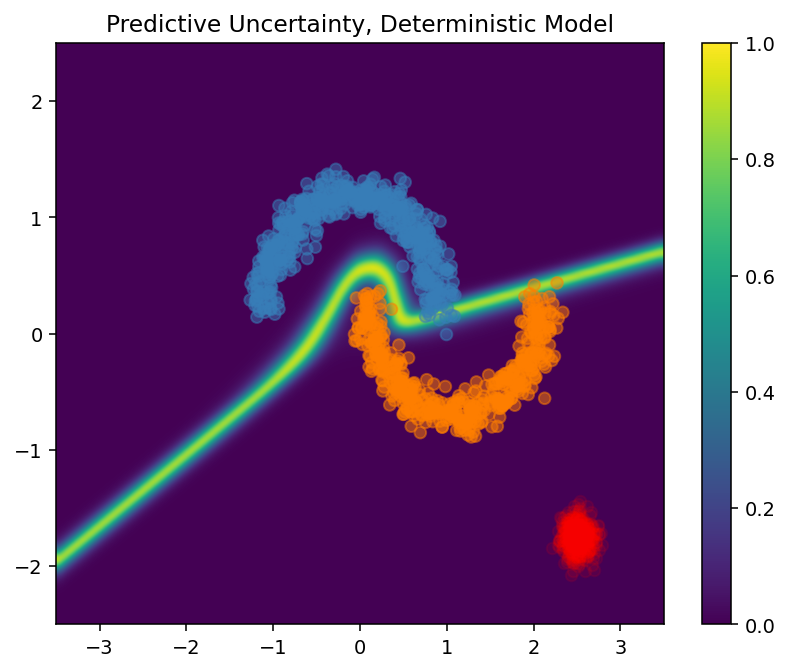

In [193]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

In the plot above, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

Let's now implement the SNGP model. Both the SNGP components, `SpectralNormalization` and `RandomFeatureGaussianProcess`, are available at the tensorflow_model's [built-in  layers](https://github.com/tensorflow/models/tree/master/official/nlp/modeling/layers). We can import these layers along with utilities for Gaussian processes using the following import:

```python
from official.nlp.modeling.layers import (
    RandomFeatureGaussianProcess,
    SpectralNormalization,
    gaussian_process,
)
```

Our goal will be twofold (as summarized by the diagram below):

1) Regularize the hidden layers of our network with spectral normalization to ensure that the distance between two input points $x$ and $x'$ is roughly preserved by the hidden layers $h$ (see [Sec. 3.2 here](https://arxiv.org/pdf/2006.10108.pdf) for more details)
2) Wrap the deterministics dense layer of our network that ouputs the logits $h(x)$ with a probabilistic layer that outputs a Gaussian distribution for the logits instead. The variance of this distribution will help us quantify the uncertainty in our model predictions: Higher variance corresponding to higher uncertainty. 

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Let's inspect these two components in more detail. (You can also jump to [the full SNGP model](#full-sngp-model) section to learn how SNGP is implemented.)

#### 1) First SNGP component: The `SpectralNormalization` (SN) layer

[`SpectralNormalization`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/spectral_normalization.py) is a Keras layer wrapper. It can be applied to an existing Dense layer like this:

```python
dense = tf.keras.layers.Dense(units=10)
dense = SpectralNormalization(dense, norm_multiplier=0.9)
```

Spectral normalization regularizes the hidden weight $W$ matrix by gradually guiding its spectral norm (that is, the largest eigenvalue of $W$) toward the target value `norm_multiplier`. 

Intutitively, the spectral norm of a dense-layer weight-matrix  controls how much the distance between input points is strecthed by the layer. Because of that, constraining the spectral norm of each of the dense layers to be close to 1 encourages the network hidden representation $h(x)$ to roughly maintain the distance between the original input points $x$. 

This way the Gaussian Proccess layer (that we describe next) which takes its input only from the hidden representation $h(x)$  will have knowledge of the original distance between the input points, which it will transform into a measure of incertainty. (See [Sec. 3.2 here](https://arxiv.org/pdf/2006.10108.pdf) for more details)


**Note:** Usually it is preferable to set `norm_multiplier` to a value smaller than 1. However in practice, it can be also relaxed to a larger value to ensure the deep network has enough expressive power.

#### 2) Second SNGP component: The Gaussian Process (GP) layer

In our deterministic network, a number of Resnet layers create a hidden representation $h$ or embeddings for the input points:

```python
embeddings = h(x_batch)
```

Then we pass these embeddings to a dense layer to create the logits (used by a sigmoid layer for classification):

```python
logits = Dense(1)(embeddings)
```

As we saw these logits are generally not distance-aware, since they their absolute values can be high far away from the data distribution, yielding very confident probabilities close to 0 or 1 when applying the final sigmoid layer:

```python
probs = tf.nn.sigmoid(logits)
```

Our goal is to scale the logits by a quantity that is large far away from the data forcing the scaled logits to be close to zero and yielding more uncertain probabilities closer to 0.5 in this case. We also want this scaling to be close to 1 rather than large in regions of the input space where we have data points. This way the scaling won't affect the quality of the classifier in regions where the data is.

How can we create such a scaling? That's where the Gaussian Process layer comes to the rescue. Instead of applying the dense layer `Dense(1)` to the embeddings, we will replace it by a Gaussiona Proccess layer

```python
sngp_logits, covmat = RandomFeatureGaussianProcess(1)(embeddings)
```

(Don't worry about the `RandomFeature` part, which is just a particular way to approximate the Gaussion Process; see [this paper](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) for details if you are interested.)

The GP layer still outputs a single logit for each data point in `x_batch`  as the dense layer `Dense(1)` was doing, but now it also outputs a **covariance matrix** `covmat` of shape `(batch_size, batch_size)` on the top of the logits. 


Basically, the GP layer outputs the mean vector of a Gaussian distribution (i.e. the vector of logits) along with its covariance matrix. In particular, the diagonal elements of this covariance matrix correspond to the  variance of each of the logits for each of the data points in the batch. We can retrieve these diagonal element as follows: 

```python
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
```

Typically, a Gaussian Process will assing a very low variance (close to zero) to points in the batch that are close to the training points, while the variance will be higher for points that are far away from the training point. We can now use this property to scale our logits:

```python

sngp_logits_adjusted = sngp_logits / tf.sqrt(1.0 + (np.pi / 8.0) * sngp_variance)
```

Observe that the scaling will be close to 1 in regions where the variance is close to zero (i.e. in regions where we have training points), while it will be large outside of that regions when the GP process variance is high. 

**Note:** See the [original tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) for an explanation on how to modify the GP process to the case of several classes.

Let's now see how to tweak the deterministic model we have been considering so far to implement SNGP on the top of it.

<a name="full-sngp-model"></a>
#### Implementation of the full SNGP model

Given the base class `DeepResNet`, the SNGP model can be implemented easily by  modifying the residual network's hidden and output layers. For compatibility with Keras `model.fit()` API, also modify the model's `call()` method so it only outputs `logits` during training.

In [251]:
class DeepResNetSNGP(DeepResNet):
    def __init__(self, spec_norm_bound=0.9, **kwargs):
        self.spec_norm_bound = spec_norm_bound
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()
        return SpectralNormalization(
            dense_layer, norm_multiplier=self.spec_norm_bound
        )

    def make_output_layer(self, num_classes):
        """Uses Gaussian process as the output layer."""
        return RandomFeatureGaussianProcess(
            num_classes, gp_cov_momentum=-1, **self.classifier_kwargs
        )

    def call(self, inputs, training=False, return_covmat=False):
        # Gets logits and a covariance matrix from the GP layer.
        logits, covmat = super().call(inputs)

        # Returns only logits during training.
        if not training and return_covmat:
            return logits, covmat

        return logits

Use the same architecture as the deterministic model.

In [252]:
resnet_config

{'num_classes': 1, 'num_layers': 6, 'num_hidden': 128}

In [253]:
sngp_model = DeepResNetSNGP(**resnet_config)

In [254]:
sngp_model.build((None, 2))
sngp_model.summary()

Model: "deep_res_net_sngp_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_279 (Dense)           multiple                  384       
                                                                 
 spectral_normalization_75 (  multiple                 16768     
 SpectralNormalization)                                          
                                                                 
 spectral_normalization_76 (  multiple                 16768     
 SpectralNormalization)                                          
                                                                 
 spectral_normalization_77 (  multiple                 16768     
 SpectralNormalization)                                          
                                                                 
 spectral_normalization_78 (  multiple                 16768     
 SpectralNormalization)                        

<a name="covariance-reset-callback"></a>
Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [255]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.classifier.reset_covariance_matrix()

Add this callback to the `DeepResNetSNGP` model class.

In [256]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

### Train model

Use `tf.keras.model.fit` to train the model.

In [257]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 2s 11ms/step - loss: 0.6378 - binary_accuracy: 0.7500
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.5698 - binary_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.5283 - binary_accuracy: 0.5030
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4969 - binary_accuracy: 0.5780
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4721 - binary_accuracy: 0.7240
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4490 - binary_accuracy: 0.8350
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4300 - binary_accuracy: 0.8950
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4113 - binary_accuracy: 0.9390
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.3951 - binary_accuracy: 0.9570
Epoch 10/100
8/8 [==============================] - 0s 

### Visualize uncertainty

First compute the predictive logits and  variances.

In [258]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)

In [259]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

<a name="mean-field-logits"></a>
Now compute the posterior predictive probability. The classic method for computing the predictive probability of a probabilistic model is to use Monte Carlo sampling, i.e.,

$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M \textrm{logit}_m(x), $$

where $M$ is the sample size, and $logit_m(x)$ are random samples from the SNGP posterior $\textrm{MultivariateNormal}$(`sngp_logits`,`sngp_covmat`). However, this approach can be slow for latency-sensitive applications such as autonomous driving or real-time bidding. Instead, you can approximate $E(p(x))$ using the [mean-field method](https://arxiv.org/abs/2006.07584):

$$E(p(x)) \approx \textrm{softmax}(\frac{\textrm{logit}(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is often chosen as $\pi/8$ or $3/\pi^2$.

In [260]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(
    1.0 + (np.pi / 8.0) * sngp_variance
)
sngp_probs = tf.nn.sigmoid(sngp_logits_adjusted)

Note: Instead of fixing $\lambda$ to a fixed value, you can also treat it as a hyperparameter, and tune it to optimize the model's calibration performance. This is known as [temperature scaling](http://proceedings.mlr.press/v70/guo17a.html) in the deep learning uncertainty literature. 

This mean-field method is implemented as a built-in function `layers.gaussian_process.mean_field_logits`:

In [261]:
def compute_posterior_mean_probability(
    logits, covmat, lambda_param=np.pi / 8.0
):
    # Computes uncertainty-adjusted logits using the built-in method.
    logits_adjusted = gaussian_process.mean_field_logits(
        logits, covmat, mean_field_factor=lambda_param
    )

    return tf.nn.sigmoid(logits_adjusted)

In [262]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

### SNGP Summary

In [263]:
def plot_predictions(pred_probs, model_name=""):
    """Plot normalized class probabilities and predictive uncertainties."""
    # Compute predictive uncertainty.
    uncertainty = pred_probs * (1.0 - pred_probs)

    # Initialize the plot axes.
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plots the class probability.
    pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
    # Plots the predictive uncertainty.
    pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

    # Adds color bars and titles.
    fig.colorbar(pcm_0, ax=axs[0])
    fig.colorbar(pcm_1, ax=axs[1])

    axs[0].set_title(f"Class Probability, {model_name}")
    axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

    plt.show()

You can now put everything together. The entire procedure—training, evaluation and uncertainty computation—can be done in just five lines:

In [264]:
def train_and_test_sngp(train_examples, test_examples):
    sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

    sngp_model.compile(**train_config)
    sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)

    sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
    sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

    return sngp_probs

In [265]:
sngp_probs = train_and_test_sngp(train_examples, test_examples)

Visualize the class probability (left) and the predictive uncertainty (right) of the SNGP model.

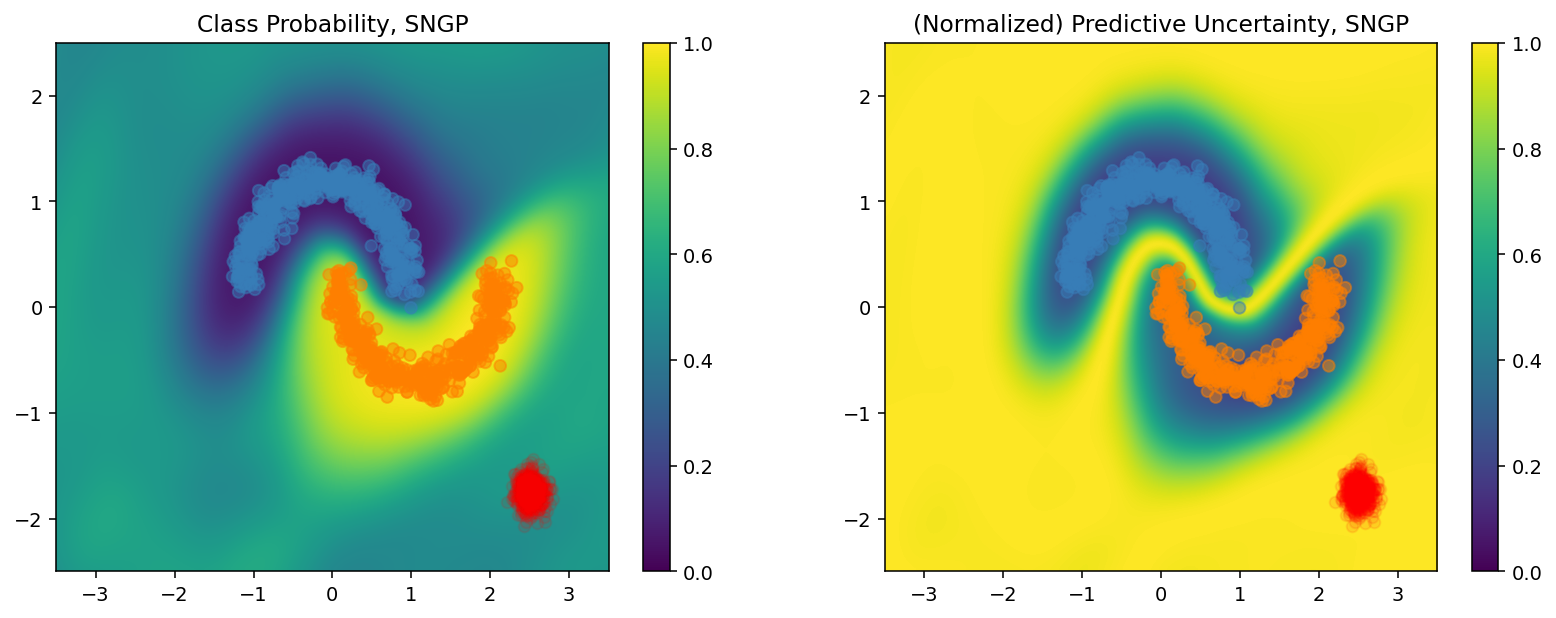

In [266]:
plot_predictions(sngp_probs, model_name="SNGP")

Remember that in the class probability plot (left), the yellow and purple are class probabilities. When close to the training data domain, SNGP correctly classifies the examples with high confidence (i.e., assigning near 0 or 1 probability). When far away from the training data, SNGP gradually becomes less confident, and its predictive probability becomes close to 0.5 while the (normalized) model uncertainty rises to 1.

Compare this to the uncertainty surface of the deterministic model: 

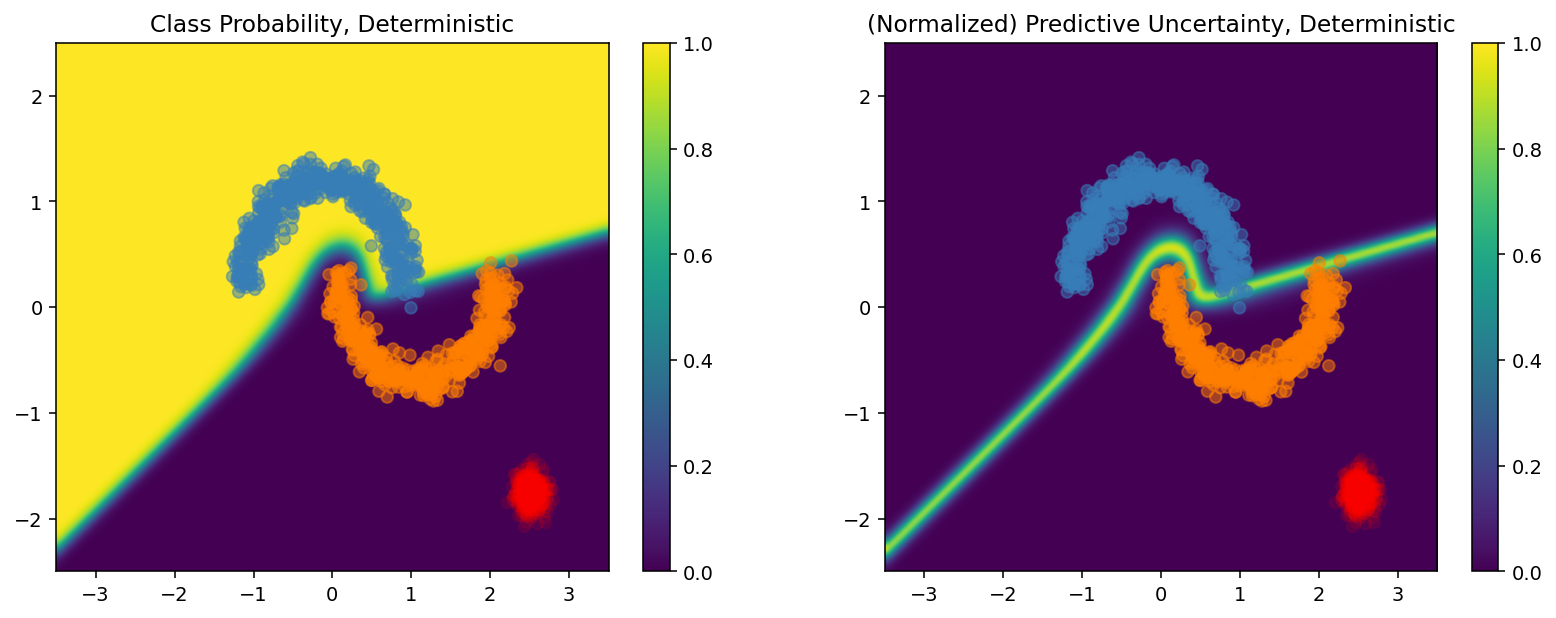

In [68]:
plot_predictions(resnet_probs, model_name="Deterministic")

As mentioned earlier, a deterministic model is not _distance-aware_. Its uncertainty is defined by the distance of the test example from the decision boundary. This leads the model to produce overconfident predictions for the out-of-domain examples (red).

## Comparison with other uncertainty approaches

This section compares the uncertainty of SNGP with [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474).

Both of these methods are based on Monte Carlo averaging of multiple forward passes of deterministic models. First, set the ensemble size $M$.

In [218]:
num_ensemble = 10

### Monte Carlo dropout

Given a trained neural network with Dropout layers, Monte Carlo dropout computes the mean predictive probability

$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M \textrm{softmax}(\textrm{logit_m}(x))$$

by averaging over multiple Dropout-enabled forward passes $\{\textrm{logit_m}(x)\}_{m=1}^M$.

In [219]:
def mc_dropout_sampling(test_examples):
    # Enable dropout during inference.
    return resnet_model(test_examples, training=True)

In [222]:
# Monte Carlo dropout inference.
dropout_logit_samples = [
    mc_dropout_sampling(test_examples) for _ in range(num_ensemble)
]
dropout_prob_samples = [
    tf.nn.sigmoid(dropout_logits) for dropout_logits in dropout_logit_samples
]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

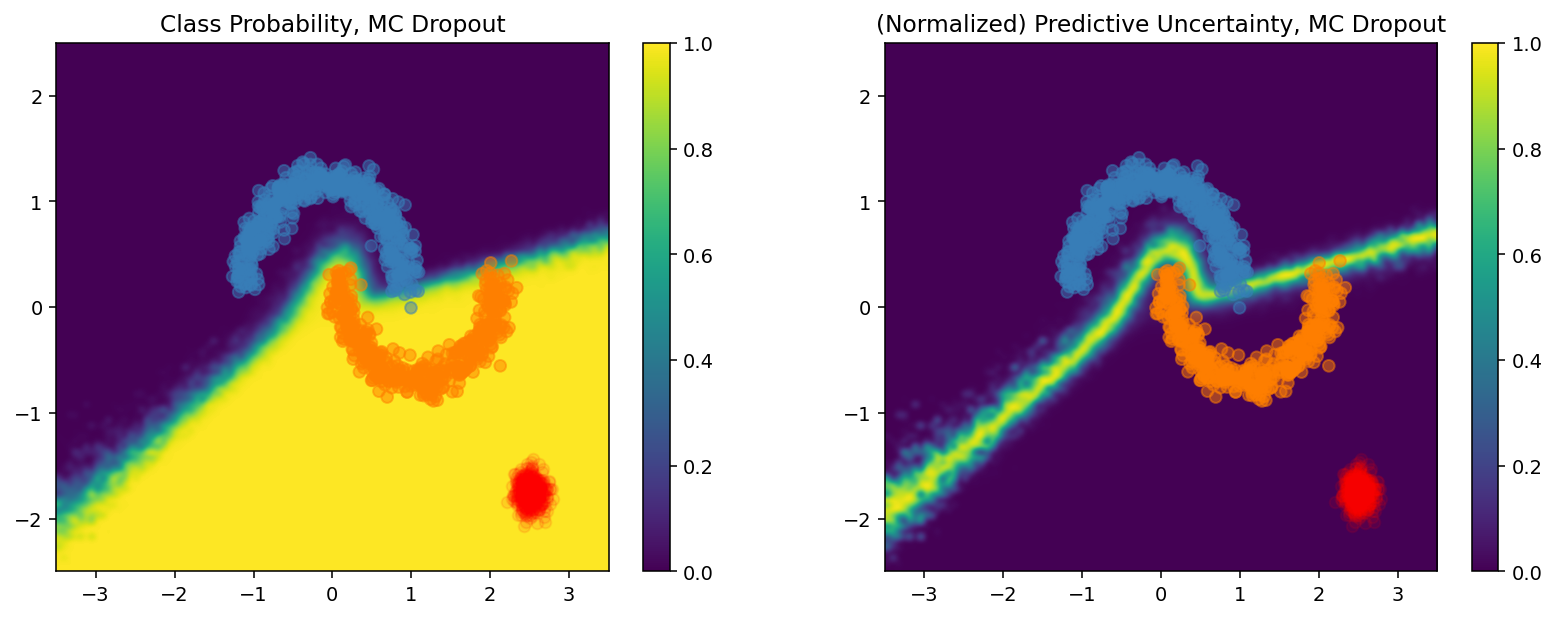

In [223]:
plot_predictions(dropout_probs, model_name="MC Dropout")

### Deep ensemble

Deep ensemble is a state-of-the-art (but expensive) method for deep learning uncertainty. To train a Deep ensemble, first train $M$ ensemble members.

In [226]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
    resnet_model = DeepResNet(**resnet_config)
    resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)

    resnet_ensemble.append(resnet_model)

Collect logits and compute the mean predictive probability $E(p(x)) = \frac{1}{M}\sum_{m=1}^M \textrm{softmax}(\textrm{logit_m}(x))$.

In [227]:
# Deep ensemble inference
ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [
    # tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples
    tf.nn.sigmoid(logits)
    for logits in ensemble_logit_samples
]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

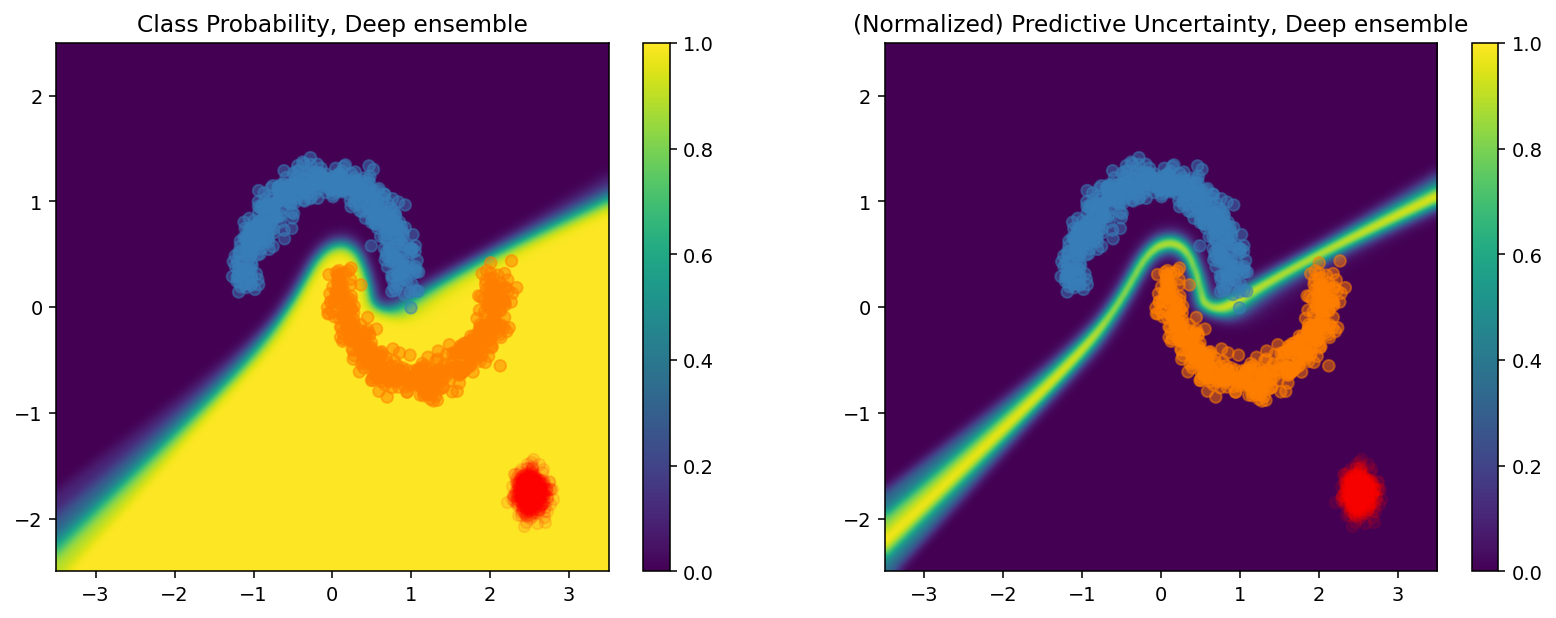

In [228]:
plot_predictions(ensemble_probs, model_name="Deep ensemble")

Both the Monte Carlo Dropout and Deep ensemble methods improve the model's uncertainty ability by making the decision boundary less certain. However, they both inherit the deterministic deep network's limitation in lacking distance awareness.

## Summary

In this tutorial, you have:
* Implemented the SNGP model on a deep classifier to improve its distance awareness.
* Trained the SNGP model end-to-end using Keras `Model.fit` API.
* Visualized the uncertainty behavior of SNGP.
* Compared the uncertainty behavior between SNGP, Monte Carlo dropout and deep ensemble models.

## Resources and further reading

* Check out the [SNGP-BERT tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert) for an example of applying SNGP on a BERT model for uncertainty-aware natural language understanding.
* Go to the [Uncertainty Baselines GitHub repo](https://github.com/google/uncertainty-baselines) for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (for example, [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper titled [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).


Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.